# Elastic wave equation implementation on a staggered grid

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from examples.seismic import plot_image, demo_model
import numpy as np

import matplotlib.pyplot as plt

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
# model = demo_model(preset='marmousi-elastic', data_path="/Users/mathiaslouboutin/research/London/CodeGen/data/")
model = demo_model(preset='layers-elastic', nlayers=5, shape=(301, 501), spacing=(10., 10.))

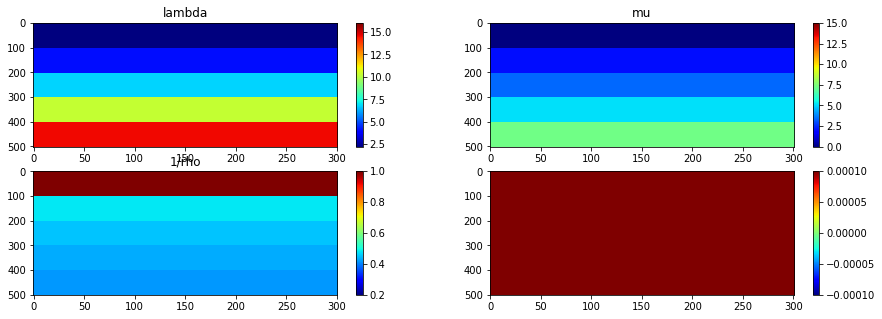

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

slices = [slice(model.nbpml, -model.nbpml), slice(model.nbpml, -model.nbpml)]

img1 = ax[0, 0].imshow(np.transpose(model.lam.data[slices]), vmin=1.5**2, vmax=4.0**2, cmap="jet")
fig.colorbar(img1, ax=ax[0, 0])
ax[0, 0].title.set_text('lambda')
ax[0, 0].set_aspect('auto')


img2 = ax[0, 1].imshow(np.transpose(model.mu.data[slices]), vmin=0, vmax=15, cmap="jet")
fig.colorbar(img2, ax=ax[0, 1])
ax[0, 1].title.set_text('mu')
ax[0, 1].set_aspect('auto')


img3 = ax[1, 0].imshow(np.transpose(model.irho.data[slices]), vmin=.2, vmax=1.0, cmap="jet")
fig.colorbar(img3, ax=ax[1, 0])
ax[1, 0].title.set_text('1/rho')
ax[1, 0].set_aspect('auto')

img4 = ax[1, 1].imshow(np.transpose(model.damp.data[slices]), vmin=-0.0001, vmax=0.0001, cmap="jet")
fig.colorbar(img4, ax=ax[1, 1])
ax[1, 1].set_aspect('auto')


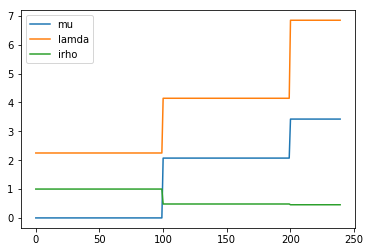

In [4]:
plt.plot(model.mu.data[200,model.nbpml:280], label='mu')
plt.plot(model.lam.data[200,model.nbpml:280], label='lamda')
plt.plot(model.irho.data[200,model.nbpml:280], label='irho')
plt.legend()

In [5]:
# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 3500.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=model.grid, f0=0.010, time_range=time_range)
src.coordinates.data[:] = [1500., 20.]

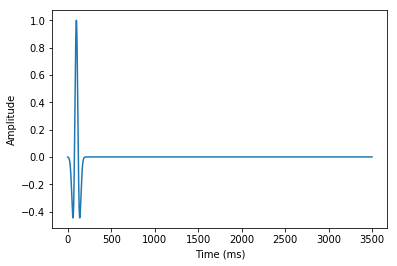

In [6]:
#NBVAL_SKIP

src.show()

# Vectorial form

While conventional litterature writes the elastic wave-equation as a set of scalar PDEs, the higher level representation comes from Hooke's law and the equation of motion and writes as:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = \lambda tr(\nabla v) \mathbf{I}  + \mu (\nabla v + (\nabla v)^T)
\end{cases}

and as $tr(\nabla v)$ is the divergence of $v$ we can reqrite it as

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = \lambda \text{diag}(\nabla . v) + \mu (\nabla v + (\nabla v)^T)
\end{cases}

where $v$ is a vector valued function:

$v(t, x, y) = (v_x(t, x, y), v_y(t, x, y)$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y) = \begin{bmatrix}\tau_{xx}(t, x, y) & \tau_{xy}(t, x, y)\\\tau_{xy}t, x, y) & \tau_{yy}(t, x, y)\end{bmatrix}$


We show in the following how to setup the elastic wave-equation form Devito's high-level tensorial types.

In [7]:
# Now we create the velocity and pressure fields
so = 4

x, z = model.grid.dimensions

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

In [8]:
# Now let's try and create the staggered updates
t = model.grid.stepping_dim
time = model.grid.time_dim
s = time.spacing

# The source injection term
src_xx = src.inject(field=tau.forward[0, 0], expr=s*src)
src_zz = src.inject(field=tau.forward[1, 1], expr=s*src)

# The receiver
nrec = 1132
rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec.coordinates.data[:, -1] = 10.

rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec2.coordinates.data[:, -1] = 10. * 63

rec3 = Receiver(name="rec3", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec3.coordinates.data[:, -1] = 10. * 63

rec_term = rec.interpolate(expr=tau[0, 0] + tau[1, 1])
rec_term += rec2.interpolate(expr=v[1])
rec_term += rec3.interpolate(expr=v[0])
# Thorbecke's parameter notation
l, mu, ro = model.lam, model.mu, model.irho

# fdelmodc reference implementation
u_v = Eq(v.forward, model.damp * (v + s*ro*div(tau)))
u_t = Eq(tau.forward,  model.damp *  (tau + s * (l * diag(div(v.forward)) +
                                                mu * (grad(v.forward) + grad(v.forward).T))))

op = Operator([u_v] + src_xx + src_zz + [u_t] + rec_term)

We can now see that both the particle velocities and stress equations are vectorial and tensorial equations. Devito takes care of the discretization and staggered grids automatically for these types of object.

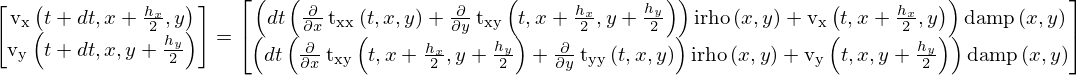

In [9]:
u_v

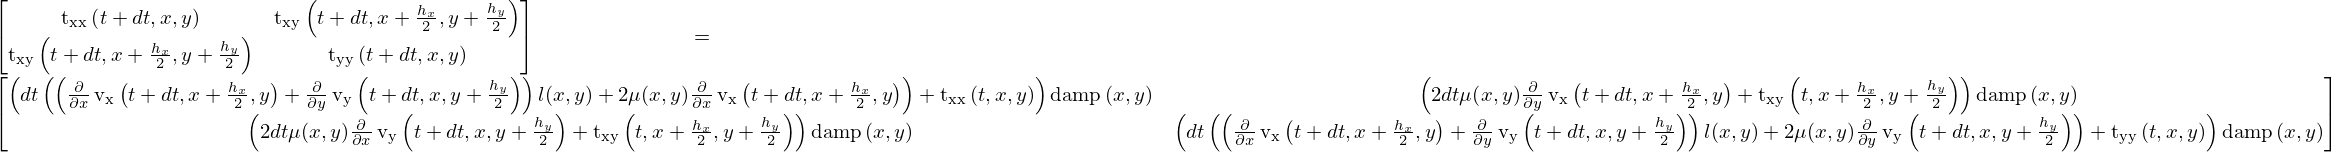

In [10]:
u_t

In [11]:
#NBVAL_IGNORE_OUTPUT
op(dt=model.critical_dt)

Operator `Kernel` run in 6.38 s


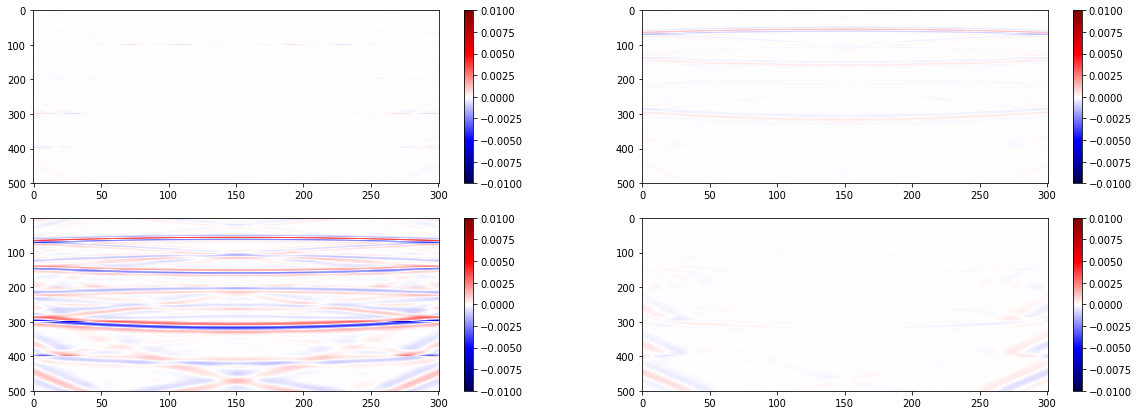

In [12]:
#NBVAL_SKIP
scale = 1e-2

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 7))

img1 = ax[0, 0].imshow(np.transpose(v[0].data[0][slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img1, ax=ax[0, 0])
ax[0, 0].set_aspect('auto')


img2 = ax[0, 1].imshow(np.transpose(v[1].data[0][slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img2, ax=ax[0, 1])
ax[0, 1].set_aspect('auto')


img3 = ax[1, 0].imshow(np.transpose(tau[0,0].data[0][slices]+tau[1,1].data[0][slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img3, ax=ax[1, 0])
ax[1, 0].set_aspect('auto')

img4 = ax[1, 1].imshow(np.transpose(tau[0,1].data[0][slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img4, ax=ax[1, 1])
ax[1, 1].set_aspect('auto')

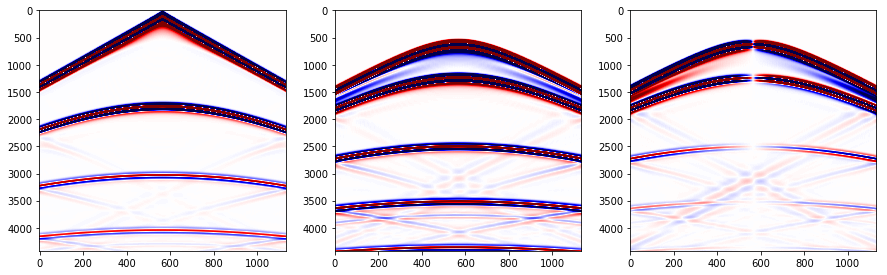

In [13]:
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(rec.data, vmin=-.01, vmax=.01, cmap="seismic", aspect=.25)
plt.subplot(132)
plt.imshow(rec2.data, vmin=-1e-3, vmax=1e-3, cmap="seismic", aspect=.25)
plt.subplot(133)
plt.imshow(rec3.data, vmin=-1e-3, vmax=1e-3, cmap="seismic", aspect=.25)

In [14]:
# Now that looks pretty! But let's do it again with a 2nd order in time
so = 4
v2 = VectorTimeFunction(name='v2', grid=model.grid, space_order=so, time_order=2)
tau0 = TensorFunction(name='t0', grid=model.grid, space_order=so)
# The source injection term
src_xx = src.inject(field=tau0[0, 0], expr=src.dt)
src_zz = src.inject(field=tau0[1, 1], expr=src.dt)

s = model.grid.time_dim.spacing
# fdelmodc reference implementation
u_v = Eq(v2.forward, model.damp * (2 * v2 - model.damp * v2.backward + s**2*ro*div(tau0)))
u_t = Eq(tau0, model.damp * (l * diag(div(v2.forward)) + mu * (grad(v2.forward) + grad(v2.forward).T)))


# rec_term = rec.interpolate(expr=tau[0, 0] + tau[1, 1])
rec_term = rec2.interpolate(expr=v2[0])
rec_term += rec3.interpolate(expr=v2[1])
op = Operator([u_v] + src_xx + src_zz + [u_t] + rec_term)


In [15]:
#NBVAL_IGNORE_OUTPUT
op(dt=model.critical_dt)

Operator `Kernel` run in 6.79 s


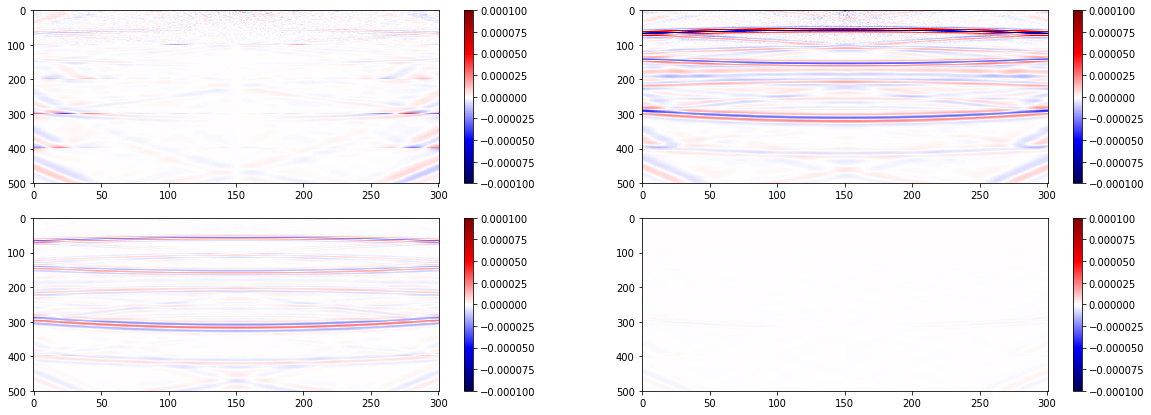

In [16]:
#NBVAL_SKIP
scale = 1e-4


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 7))

img1 = ax[0, 0].imshow(np.transpose(v2[0].data[0][slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img1, ax=ax[0, 0])
ax[0, 0].set_aspect('auto')


img2 = ax[0, 1].imshow(np.transpose(v2[1].data[0][slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img2, ax=ax[0, 1])
ax[0, 1].set_aspect('auto')


img3 = ax[1, 0].imshow(np.transpose(tau0[0,0].data[slices]+tau0[1,1].data[slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img3, ax=ax[1, 0])
ax[1, 0].set_aspect('auto')

img4 = ax[1, 1].imshow(np.transpose(tau0[0,1].data[slices]), vmin=-scale, vmax=scale, cmap="seismic")
fig.colorbar(img4, ax=ax[1, 1])
ax[1, 1].set_aspect('auto')

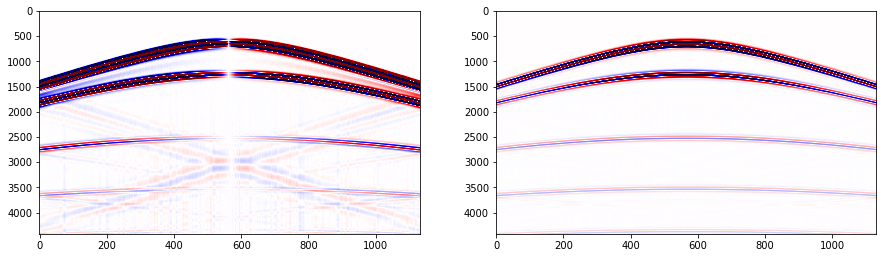

In [17]:
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(rec2.data, vmin=-1e-4, vmax=1e-4, cmap="seismic", aspect=.15)
plt.subplot(122)
plt.imshow(rec3.data, vmin=-1e-3, vmax=1e-3, cmap="seismic", aspect=.15)